In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential,layers
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer,text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import brown,stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec,KeyedVectors
from gensim.test.utils import get_tmpfile
import multiprocessing
from time import time
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
#nltk.download()
cores=multiprocessing.cpu_count()
print("Number of cores in the server :",cores)

Number of cores in the server : 4


In [3]:
filePath='../input/subjects/Subject_Wise_Data.json'
#filePath2='../input/musicdata/Digital_Music_5.json'
#filePathLocal='datasets/Digital_Music_5.json'
filePathGlove='../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt'

In [4]:
df=pd.read_json(filePath,lines=False)

In [5]:
df.head()

,ExtractedText,Topic
0,Section 7.7\n\n‘SYNCHRONIC\n\n‘CAUSALRULES\n\n...,1
1,24\n\n(CHAPTER ONE Digital Logic Circuits\n\n ...,1
2,control address\nregister\n\nsequencer\n\npipe...,1
3,start bit\n\nstop bit\n\nSECTION 11-3 Asynchro...,1
4,"9.4 Paging 293\n\nhowever, allow the page tabl...",1


In [6]:
#Preprocessing the whole text
english_stop_words=set(stopwords.words('english'))
lemma=WordNetLemmatizer()
def preprocess_data(paragraph):
    paragraph=re.sub('[^a-zA-Z,]',' ',paragraph)                               #Removing numbers and punctuations
    paragraph=paragraph.strip()                                                #remove newline characters
    paragraph=str(paragraph).lower()                                           #Converting all characters into lowercase
    paragraph=text_to_word_sequence(paragraph)                                 #Tokenization
    paragraph=[word for word in paragraph if word not in english_stop_words]   #Stopwords removal (Stopwords are the frequently occurring words like 'the','and','or','that','this',etc which carry no contextual information.)
    paragraph=[lemma.lemmatize(word=word,pos='v') for word in paragraph]       #Lemmatization -> Keeping the root of the words
    paragraph=[word for word in paragraph if len(word) > 2]                    #removing all words with length<=2 like 'a','an','or','by','me',etc.
    paragraph=' '.join(paragraph)                                              #Converting the current list to string
    return paragraph

In [7]:
t1=time()
PreprocessedText=df['ExtractedText'].apply(preprocess_data)
t2=time()
print("Preprcessing took {0} secs".format(t2-t1))

Preprcessing took 19.83096694946289 secs


In [8]:
df.insert(1,'PreprocessedText',PreprocessedText)
df=df.sample(frac=1,random_state=6).reset_index(drop=True)  #Shuffling the records

In [9]:
df.head()

,ExtractedText,PreprocessedText,Topic
0,we ‘COORDINATION COMPOUNDS:\nINATION COMPOUNDS...,coordination compound ination compound nhy ato...,0
1,Chapter 3: The Loop Control Structure 133\n\n ...,chapter loop control structure write program p...,1
2,\n\n232\n\nCHAPTER 9 CENTER OF MASS AND LINEA...,chapter center mass linear momentum sample pro...,0
3,204\n\n9°22 <r A 60 kg skier starts from rest ...,skier start rest height mabove end ofa ski jum...,0
4,22-3 THE ELECTRIC FIELD DUE TO A DIPOLE\n\nWe ...,electric field due dipole next must find orien...,0


In [10]:
X=df['PreprocessedText'].values
y=df['Topic'].values
X_tokens=[]
for sentence in X:
    X_tokens.append(sentence.split())
    
#print(X_tokens[3])

In [11]:
L=[]
for text in X_tokens:
    for word in text:
        L.append(word)
num_unique_tokens=len(set(L))
#print(set(L))
print(num_unique_tokens)

57842


In [12]:
"""MAX_DOCUMENT_LENGTH=np.max([len(text.split()) for text in X])
tokenizer=Tokenizer()
tokenizer.fit_on_texts(X)
sequences=tokenizer.texts_to_sequences(X)
X=pad_sequences(sequences,maxlen=MAX_DOCUMENT_LENGTH)
word_index=tokenizer.word_index
print("Found {0} unique tokens".format(len(word_index)))"""

'MAX_DOCUMENT_LENGTH=np.max([len(text.split()) for text in X])\ntokenizer=Tokenizer()\ntokenizer.fit_on_texts(X)\nsequences=tokenizer.texts_to_sequences(X)\nX=pad_sequences(sequences,maxlen=MAX_DOCUMENT_LENGTH)\nword_index=tokenizer.word_index\nprint("Found {0} unique tokens".format(len(word_index)))'

In [13]:
X_train, X_test, y_train, y_test=\
train_test_split(X,y,test_size=0.30,random_state=62)

In [14]:
EMB_DIM=100
t1=time()
w2v=Word2Vec(X_tokens,
             size=EMB_DIM,
             window=70,
             min_count=1,
             iter=10,
             workers=multiprocessing.cpu_count())
t2=time()
print("Preparation of custom Word Embeddings took {0} minutes".format((t2-t1)/60))

Preparation of custom Word Embeddings took 1.3307416796684266 minutes


In [15]:
word_vectors=w2v.wv

In [16]:
print(type(word_vectors))
f="./subjects.100d.bin"
word_vectors.save(f)

<class 'gensim.models.keyedvectors.Word2VecKeyedVectors'>


In [17]:
word_vectors=KeyedVectors.load(f,mmap='r')

In [18]:
word2index={key:value.index for (key,value) in word_vectors.vocab.items()}

In [19]:
print(len(word_vectors.vocab))

57842


In [20]:
def test_similarity(text):
    result=word_vectors.similar_by_word(text)
    print("Most similar words to {0} are:  ".format(text),result[:3])

In [21]:
test_similarity("queue")
test_similarity("network")
test_similarity("flower")
test_similarity("stack")
test_similarity("genes")
test_similarity("vector")

Most similar words to queue are:   [('rkey', 0.5561319589614868), ('pending', 0.4991931915283203), ('whileq', 0.49315372109413147)]
Most similar words to network are:   [('topology', 0.6179526448249817), ('bryson', 0.6080610752105713), ('sejnowski', 0.5889403223991394)]
Most similar words to flower are:   [('petals', 0.7874423861503601), ('stamens', 0.7541207671165466), ('floral', 0.7344789505004883)]
Most similar words to stack are:   [('pop', 0.6487277746200562), ('contarn', 0.5600948333740234), ('togethet', 0.5254797339439392)]
Most similar words to genes are:   [('gene', 0.7932099103927612), ('polymorphisms', 0.6707456707954407), ('drosophila', 0.6596246957778931)]
Most similar words to vector are:   [('vectors', 0.7822043895721436), ('pulted', 0.6223251819610596), ('fruitcake', 0.6065764427185059)]


In [22]:
def pca_2Dplot(model,words=None,sample=0):
    if words == None:
        if sample>0:
            words = np.random.choice(list(model.vocab.keys()),sample)
        else:
            words = [word for word in model.vocab]
    
    wordVectors=np.array([model[w] for w in words])
    wordVectors2D=PCA().fit_transform(wordVectors)[:,:2]
    plt.figure(figsize=(6,6))
    plt.scatter(wordVectors2D[:,0], wordVectors2D[:,1],edgecolors='k',c='r')
    for word,(x,y) in zip(words,wordVectors2D):
        plt.text(x+0.05,y+0.05,word)

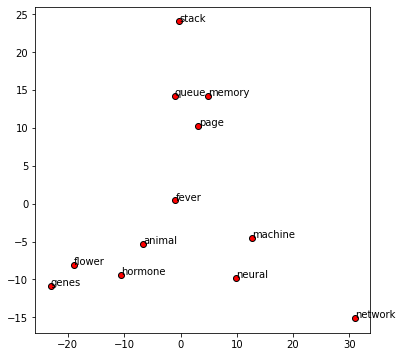

In [23]:
pca_2Dplot(word_vectors,words=['queue','network','stack','genes','flower','animal','neural','machine','page','memory','hormone','fever'],sample=0)

In [24]:
def create_embedding_matrix(word_vectors,word2index,embedding_dim):
    unk=0
    vocab_size=len(word_vectors.vectors)+1
    embedding_matrix=np.zeros((vocab_size,embedding_dim))
    for (word,idx) in word2index.items():
        embedding_matrix[idx]=word_vectors[word]
    return unk,embedding_matrix

In [25]:
vocab_size=len(word_vectors.vectors)+1
embedding_dim=100                    
unknown_count,embedding_matrix=create_embedding_matrix(word_vectors,word2index,embedding_dim)

In [26]:
print(embedding_matrix.shape)

(57843, 100)


In [27]:
def stringToTensor(data,word2index):
    Sequence=[]
    unk=0
    for sentence in data:
        sentence=sentence.split()
        tensor=[]
        for word in sentence:
            if word in word2index:
                tensor.append(word2index[word])
            else:
                unk+=1
        Sequence.append(tensor)
    return unk,Sequence

In [28]:
unk_count,X_train_tensor=stringToTensor(X_train,word2index)
unk_count_test,X_test_tensor=stringToTensor(X_test,word2index)

In [29]:
print(unk_count)
print(unk_count_test)

0
0


In [30]:
"""
EOS_INDEX=1
EOS_TOKEN="EOS"
def split_data_into_contexts(context_size,word2id,X_data,Y_data):
    Xc=[]
    Yc=[]
    unk_count=0
    span=2*context_size+1
    buffer=collections.deque(maxlen=span)
    padding=[(EOS_TOKEN,None)]*context_size
    buffer+=padding+X_data[:context_size]
    for item in (X_data[context_size]+padding):
        buffer.append(item)
        window_ids=np.array([word2id[word] if (word in word2id) else UNK_INDEX])
"""

'\nEOS_INDEX=1\nEOS_TOKEN="EOS"\ndef split_data_into_contexts(context_size,word2id,X_data,Y_data):\n    Xc=[]\n    Yc=[]\n    unk_count=0\n    span=2*context_size+1\n    buffer=collections.deque(maxlen=span)\n    padding=[(EOS_TOKEN,None)]*context_size\n    buffer+=padding+X_data[:context_size]\n    for item in (X_data[context_size]+padding):\n        buffer.append(item)\n        window_ids=np.array([word2id[word] if (word in word2id) else UNK_INDEX])\n'

In [31]:
MAX_DOCUMENT_LENGTH=np.max([len(text.split()) for text in X_train])
Context_length=MAX_DOCUMENT_LENGTH

In [32]:
X_train_tensor=pad_sequences(X_train_tensor,padding='post',maxlen=MAX_DOCUMENT_LENGTH)
X_test_tensor=pad_sequences(X_test_tensor,padding='post',maxlen=MAX_DOCUMENT_LENGTH)

In [33]:
modelBase1=Sequential()
modelBase1.add(layers.Dense(700,input_dim=MAX_DOCUMENT_LENGTH,activation='relu'))
modelBase1.add(layers.Dense(800,activation='relu'))
modelBase1.add(layers.Dense(1,activation='sigmoid'))
modelBase1.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
modelBase1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 700)               404600    
_________________________________________________________________
dense_1 (Dense)              (None, 800)               560800    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 801       
Total params: 966,201
Trainable params: 966,201
Non-trainable params: 0
_________________________________________________________________


In [34]:
t1=time()
modelBase1.fit(X_train_tensor,
              y_train,
              batch_size=32,
              epochs=12,
              verbose=True,
              validation_data=(X_test_tensor,y_test))
t2=time()
print("Base model 1 took {} secs to train".format(t2-t1))

Epoch 1/12
159/159 [==============================] - 1s 8ms/step - loss: 418.9338 - accuracy: 0.6071 - val_loss: 90.8153 - val_accuracy: 0.6265
Epoch 2/12
159/159 [==============================] - 1s 8ms/step - loss: 29.1766 - accuracy: 0.7697 - val_loss: 50.6229 - val_accuracy: 0.6274
Epoch 3/12
159/159 [==============================] - 1s 7ms/step - loss: 7.6601 - accuracy: 0.8653 - val_loss: 44.2735 - val_accuracy: 0.6421
Epoch 4/12
159/159 [==============================] - 1s 7ms/step - loss: 3.4448 - accuracy: 0.9164 - val_loss: 41.9801 - val_accuracy: 0.6619
Epoch 5/12
159/159 [==============================] - 1s 7ms/step - loss: 1.7496 - accuracy: 0.9470 - val_loss: 44.7712 - val_accuracy: 0.6536
Epoch 6/12
159/159 [==============================] - 1s 7ms/step - loss: 1.9018 - accuracy: 0.9472 - val_loss: 54.3247 - val_accuracy: 0.6536
Epoch 7/12
159/159 [==============================] - 1s 7ms/step - loss: 1.9124 - accuracy: 0.9503 - val_loss: 52.2784 - val_accuracy: 0.6

In [35]:
scalar1=MinMaxScaler()
scalar2=MinMaxScaler()
scalar1.fit(X_train_tensor)
X_train_norm=scalar1.transform(X_train_tensor)
scalar2.fit(X_test_tensor)
X_test_norm=scalar2.transform(X_test_tensor)

modelBase2=LogisticRegression(max_iter=1700)
modelBase2.fit(X_train_norm,y_train)
y_pred_train=modelBase2.predict(X_train_norm)
score_train=accuracy_score(y_train,y_pred_train)
y_pred_test=modelBase2.predict(X_test_norm)
score_test=accuracy_score(y_test,y_pred_test)
print("Training Accuracy : {0}".format(score_train))
print("Testing  Accuracy : {0}".format(score_test))

Training Accuracy : 0.7578864353312302
Testing  Accuracy : 0.7299908003679852


In [36]:
model_C1=Sequential()
model_C1.add(layers.Embedding(embedding_matrix.shape[0],
                           embedding_dim,
                           weights=[embedding_matrix],
                           input_length=Context_length,
                           trainable=False))
#modelG.add(layers.GlobalMaxPool1D())
model_C1.add(layers.Flatten())
model_C1.add(layers.Dense(380,activation="relu"))
model_C1.add(layers.Dense(1,activation="sigmoid"))
model_C1.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model_C1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 577, 100)          5784300   
_________________________________________________________________
flatten (Flatten)            (None, 57700)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 380)               21926380  
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 381       
Total params: 27,711,061
Trainable params: 21,926,761
Non-trainable params: 5,784,300
_________________________________________________________________


In [37]:
print(X_train_tensor.shape)
print(X_test_tensor.shape)

(5072, 577)
(2174, 577)


In [38]:
t1=time()
model_C1.fit(X_train_tensor,y_train,
          batch_size=128,
          epochs=10,
          verbose=True,
          validation_data=(X_test_tensor,y_test))
t2=time()
print("Candidate Model 1 took {} secs to train".format(t2-t1))

Epoch 1/10
40/40 [==============================] - 6s 154ms/step - loss: 24.0261 - accuracy: 0.8200 - val_loss: 0.9167 - val_accuracy: 0.9535
Epoch 2/10
40/40 [==============================] - 6s 148ms/step - loss: 0.3596 - accuracy: 0.9858 - val_loss: 0.2284 - val_accuracy: 0.9917
Epoch 3/10
40/40 [==============================] - 6s 154ms/step - loss: 0.1347 - accuracy: 0.9925 - val_loss: 0.1967 - val_accuracy: 0.9913
Epoch 4/10
40/40 [==============================] - 6s 160ms/step - loss: 0.2319 - accuracy: 0.9888 - val_loss: 0.2526 - val_accuracy: 0.9894
Epoch 5/10
40/40 [==============================] - 6s 158ms/step - loss: 0.1139 - accuracy: 0.9927 - val_loss: 0.2389 - val_accuracy: 0.9917
Epoch 6/10
40/40 [==============================] - 6s 148ms/step - loss: 0.1471 - accuracy: 0.9911 - val_loss: 0.3010 - val_accuracy: 0.9908
Epoch 7/10
40/40 [==============================] - 6s 148ms/step - loss: 0.0452 - accuracy: 0.9970 - val_loss: 0.3693 - val_accuracy: 0.9834
Epoch

In [39]:
def load_trained_embeddings(pathToEmbedding,word2idx,embedding_dim):
    vocab_length=len(word2idx)+1
    embedding_matrix=np.zeros((vocab_length,embedding_dim))
    f=open(pathToEmbedding,"r")
    for line in f:
        entry=line.split()
        if entry[0] in word2idx:
            index_of_word=word2idx[entry[0]]
            embedding_matrix[index_of_word]=np.asarray(entry[1:],dtype='float32')
    f.close()
    return embedding_matrix

In [40]:
embedding_matrix_pretrained=load_trained_embeddings(filePathGlove,word2index,100)

In [41]:
model_C2=Sequential()
model_C2.add(layers.Embedding(embedding_matrix_pretrained.shape[0],
                           embedding_dim,
                           weights=[embedding_matrix_pretrained],
                           input_length=Context_length,
                           trainable=False))
#modelG.add(layers.GlobalMaxPool1D())
model_C2.add(layers.Flatten())
model_C2.add(layers.Dense(380,activation="relu"))
model_C2.add(layers.Dense(1,activation="sigmoid"))
model_C2.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model_C2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 577, 100)          5784300   
_________________________________________________________________
flatten_1 (Flatten)          (None, 57700)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 380)               21926380  
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 381       
Total params: 27,711,061
Trainable params: 21,926,761
Non-trainable params: 5,784,300
_________________________________________________________________


In [42]:
t1=time()
model_C2.fit(X_train_tensor,
          y_train,
          batch_size=128,
          epochs=10,
          verbose=True,
          validation_data=(X_test_tensor,y_test))
t2=time()
print("The candidate model 2 took {0} secs to train".format(t2-t1))

Epoch 1/10
40/40 [==============================] - 6s 150ms/step - loss: 3.4953 - accuracy: 0.7563 - val_loss: 0.1562 - val_accuracy: 0.9388
Epoch 2/10
40/40 [==============================] - 7s 173ms/step - loss: 0.1018 - accuracy: 0.9750 - val_loss: 0.0956 - val_accuracy: 0.9798
Epoch 3/10
40/40 [==============================] - 6s 152ms/step - loss: 0.0738 - accuracy: 0.9823 - val_loss: 0.0836 - val_accuracy: 0.9724
Epoch 4/10
40/40 [==============================] - 6s 161ms/step - loss: 0.0533 - accuracy: 0.9880 - val_loss: 0.0716 - val_accuracy: 0.9821
Epoch 5/10
40/40 [==============================] - 6s 153ms/step - loss: 0.0422 - accuracy: 0.9917 - val_loss: 0.0726 - val_accuracy: 0.9775
Epoch 6/10
40/40 [==============================] - 6s 147ms/step - loss: 0.0350 - accuracy: 0.9941 - val_loss: 0.0623 - val_accuracy: 0.9844
Epoch 7/10
40/40 [==============================] - 6s 152ms/step - loss: 0.0292 - accuracy: 0.9949 - val_loss: 0.0595 - val_accuracy: 0.9862
Epoch 

In [43]:
def createSample(Xs):

    """
    for word in words:
        if word in word2index:
            Xs.append(word2index[word])
    print(Xs)
    """
    unk_count,Xs_tensor=stringToTensor(Xs,word2index)
    Xs_tensor=pad_sequences(sequences=Xs_tensor,padding='post',maxlen=MAX_DOCUMENT_LENGTH)
    return Xs_tensor

In [44]:
test1='machine memory binary stack gene flower seed animal'*69
test1=createSample([test1])

In [45]:
result=model_C1.predict(test1)
print(result[0][0])

1.0


In [46]:
test2='flower gene pollination '*147
test2=createSample([test2])

In [47]:
print(model_C1.predict(test2)[0][0])

0.0


In [48]:
print("Candidate Model 1 statistics:")
loss,accuracy=model_C1.evaluate(X_train_tensor,y_train)
print("Training accuracy= {:.4f}".format(accuracy))
loss,accuracy=model_C1.evaluate(X_test_tensor,y_test)
print("Testing accuracy= {:.4f}".format(accuracy))

Candidate Model 1 statistics:
159/159 [==============================] - 3s 21ms/step - loss: 0.0473 - accuracy: 0.9972
Training accuracy= 0.9972
68/68 [==============================] - 1s 19ms/step - loss: 0.2045 - accuracy: 0.9936
Testing accuracy= 0.9936


In [49]:
print("Candidate Model 2 statistics:")
loss,accuracy=model_C2.evaluate(X_train_tensor,y_train)
print("Training accuracy= {:.4f}".format(accuracy))
loss,accuracy=model_C2.evaluate(X_test_tensor,y_test)
print("Testing accuracy= {:.4f}".format(accuracy))

Candidate Model 2 statistics:
159/159 [==============================] - 4s 23ms/step - loss: 0.0154 - accuracy: 0.9986
Training accuracy= 0.9986
68/68 [==============================] - 1s 19ms/step - loss: 0.0532 - accuracy: 0.9862
Testing accuracy= 0.9862


In [50]:
model_C1.save("./model_C1")
model_C2.save("./model_C2")